In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# 1. Load the data
# Replace this with your file path or read directly if it's in memory
df = pd.read_csv("client_4_binary.csv") 



# 3. Features and target separation
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]




In [43]:
# 4. Optional: Scale BMI, MentHlth, PhysHlth for better performance
scaler = StandardScaler()
columns_to_scale = ["BMI", "MentHlth", "PhysHlth"]
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



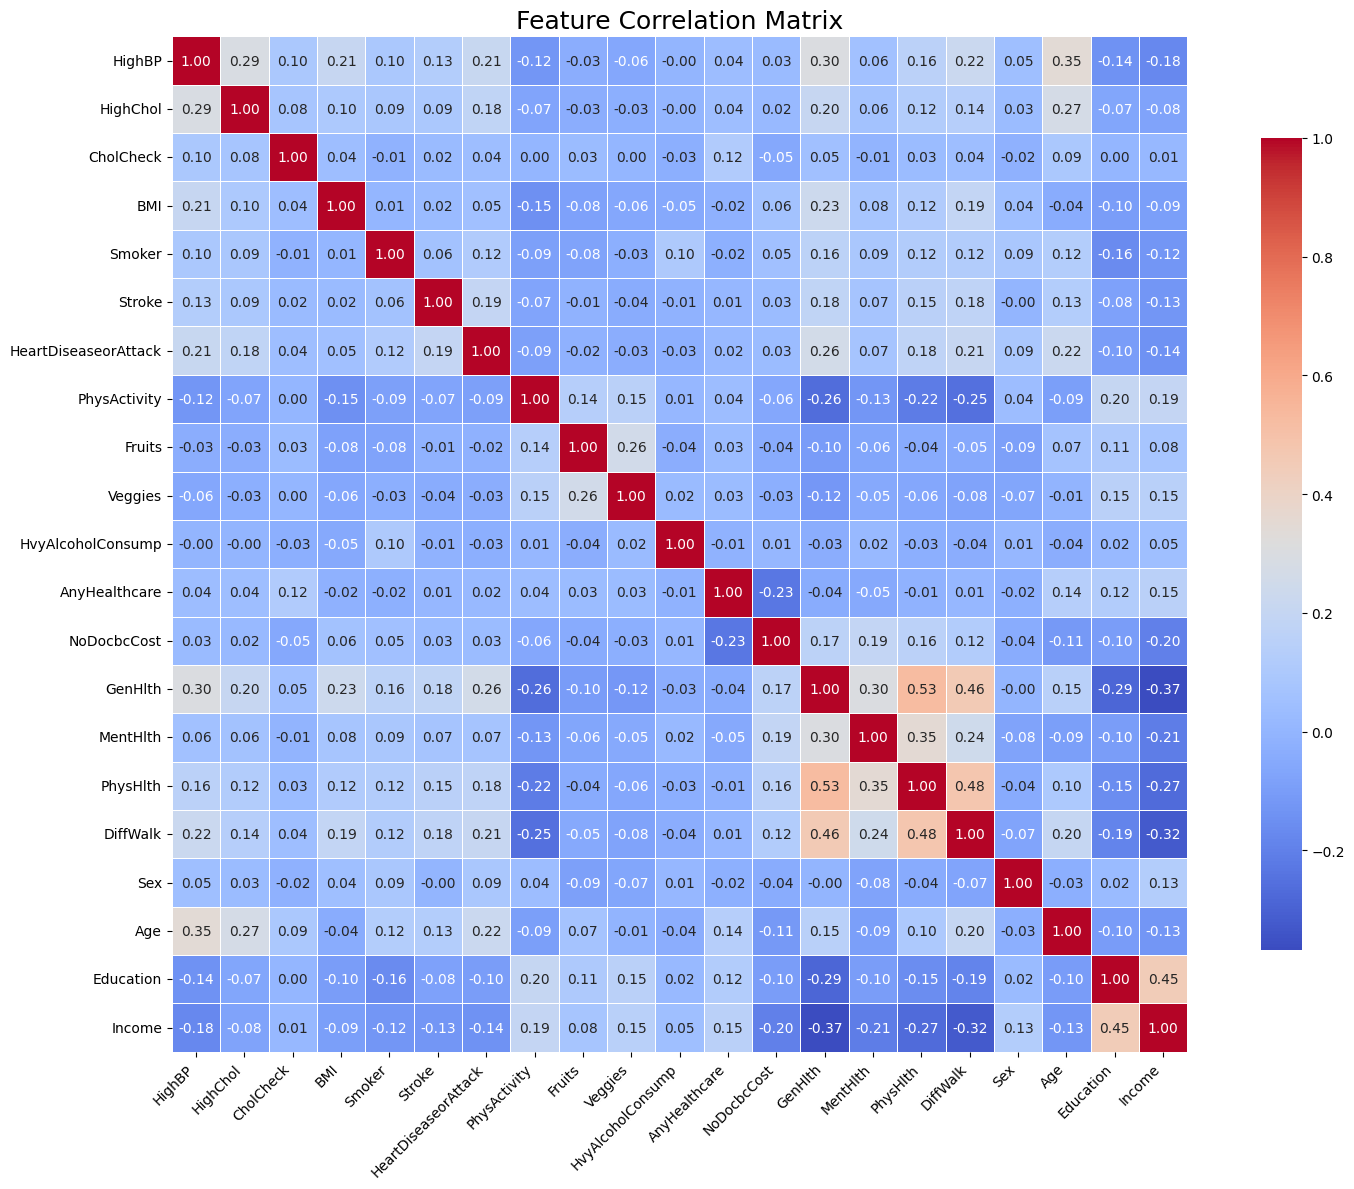

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
corr_matrix = X.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)

plt.title("Feature Correlation Matrix", fontsize=18)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [45]:
# Check class counts in full dataset
print("Full dataset class counts:")
print(y.value_counts())

# Check class counts in training set
print("\nTraining set class counts:")
print(y_train.value_counts())

# Check class counts in test set
print("\nTest set class counts:")
print(y_test.value_counts())


Full dataset class counts:
Diabetes_binary
0.0    54587
1.0     8833
Name: count, dtype: int64

Training set class counts:
Diabetes_binary
0.0    43670
1.0     7066
Name: count, dtype: int64

Test set class counts:
Diabetes_binary
0.0    10917
1.0     1767
Name: count, dtype: int64


In [46]:
# # 6. Model training
# xgb_model = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     use_label_encoder=False,
#     random_state=42
# )

# xgb_model.fit(X_train, y_train)

# # 7. Predictions
# y_pred = xgb_model.predict(X_test)
# y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# # 8. Evaluation
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [47]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Redefine train/test split if needed
# (You already have X_train, X_test, y_train, y_test)

def objective(trial):
    # Suggested hyperparameters
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
        "use_label_encoder": False,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 10),  # imbalance control
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

# Run the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Show best params and best AUC
print("Best trial:")
print("  AUC: {:.5f}".format(study.best_value))
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-07-26 11:47:55,890] A new study created in memory with name: no-name-2e58ac44-1e2d-40ff-a2d2-51c23f7a5cff
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:47:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-26 11:47:56,462] Trial 0 finished with value: 0.8245290297905081 and parameters: {'max_depth': 8, 'learning_rate': 0.21773681902902975, 'n_estimators': 410, 'subsample': 0.9131416116531474, 'colsample_bytree': 0.5165578521864179, 'gamma': 2.216433787674792, 'scale_pos_weight': 3.1511278511078737}. Best is trial 0 with value: 0.8245290297905081.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:47:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not use

Best trial:
  AUC: 0.83817
  Params: 
    max_depth: 3
    learning_rate: 0.055264981333567116
    n_estimators: 221
    subsample: 0.9710595321266019
    colsample_bytree: 0.9709380477138461
    gamma: 1.463342311028444
    scale_pos_weight: 4.91225450169468


In [48]:
# Calculate manual scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

6.180300028304557


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report at threshold 0.3
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78     10917
         1.0       0.28      0.83      0.42      1767

    accuracy                           0.68     12684
   macro avg       0.62      0.74      0.60     12684
weighted avg       0.86      0.68      0.73     12684



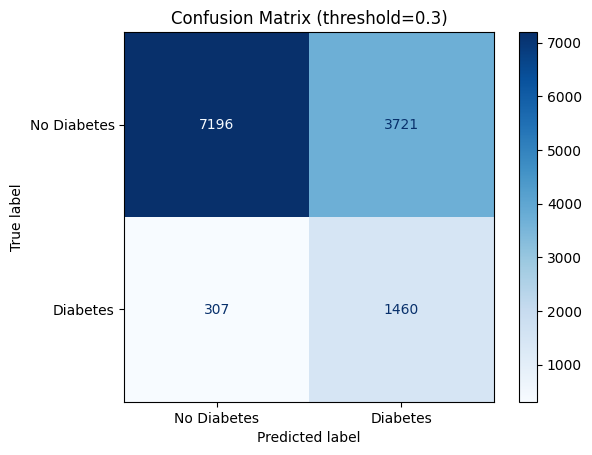

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



# Set parameters (include best Optuna ones)
params = {
    "max_depth": 7,
    "learning_rate": 0.2,
    "n_estimators": 300,
    "subsample": 0.91,
    "colsample_bytree": 0.88,
    "gamma": 2.02,
    "scale_pos_weight": 4,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "use_label_encoder": False
}

model = XGBClassifier(**params)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Set custom threshold (e.g., 0.3)
threshold = 0.3
y_pred_custom = (y_pred_proba >= threshold).astype(int)

# Evaluate
print("Classification Report at threshold", threshold)
print(classification_report(y_test, y_pred_custom))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()


In [50]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    print(f"Threshold: {thresh:.2f}, F1-score: {f1:.4f}")

best_thresh = thresholds[np.argmax(recall_score)]
print(f"Best threshold by F1 score: {best_thresh:.2f}")

# Use best threshold
y_pred_best = (y_pred_proba >= 0.3).astype(int)
print(classification_report(y_test, y_pred_best))


Threshold: 0.10, F1-score: 0.3394
Threshold: 0.15, F1-score: 0.3640
Threshold: 0.20, F1-score: 0.3838
Threshold: 0.25, F1-score: 0.4044
Threshold: 0.30, F1-score: 0.4203
Threshold: 0.35, F1-score: 0.4334
Threshold: 0.40, F1-score: 0.4485
Threshold: 0.45, F1-score: 0.4589
Threshold: 0.50, F1-score: 0.4647
Threshold: 0.55, F1-score: 0.4654
Threshold: 0.60, F1-score: 0.4530
Threshold: 0.65, F1-score: 0.4253
Threshold: 0.70, F1-score: 0.3840
Threshold: 0.75, F1-score: 0.3180
Threshold: 0.80, F1-score: 0.2320
Threshold: 0.85, F1-score: 0.1518
Best threshold by F1 score: 0.10
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78     10917
         1.0       0.28      0.83      0.42      1767

    accuracy                           0.68     12684
   macro avg       0.62      0.74      0.60     12684
weighted avg       0.86      0.68      0.73     12684



In [51]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Set best parameters
# best_params = {
#     "max_depth": 3,
#     "learning_rate": 0.12521978552821053,
#     "n_estimators": 159,
#     "subsample": 0.9148533105154012,
#     "colsample_bytree": 0.8817561229610835,
#     "gamma": 2.023281844613396,
#     "scale_pos_weight": 4.214807824184553,
#     "objective": "binary:logistic",
#     "eval_metric": "logloss",
#     "random_state": 42,
#     "use_label_encoder": False
# }

# # Train final model
# final_model = XGBClassifier(**best_params)
# final_model.fit(X_train, y_train)

# # Predictions
# y_pred = final_model.predict(X_test)
# y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# # Evaluation
# print("Final Model Evaluation:")
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Precision:", precision_score(y_test, y_pred))
# print("Recall:", recall_score(y_test, y_pred))
# print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Diabetes", "Diabetes"])
# disp.plot(cmap="Blues", values_format="d")
# plt.title("Confusion Matrix")
# plt.show()


In [52]:
# Correlation with target
target_corr = df.corr()["Diabetes_binary"].sort_values(ascending=False)
print(target_corr)


Diabetes_binary         1.000000
GenHlth                 0.290904
HighBP                  0.261056
BMI                     0.217091
DiffWalk                0.215312
HighChol                0.190661
HeartDiseaseorAttack    0.176406
Age                     0.174767
PhysHlth                0.169225
Stroke                  0.106034
MentHlth                0.068905
CholCheck               0.065042
Smoker                  0.058700
NoDocbcCost             0.036466
Sex                     0.030056
AnyHealthcare           0.011701
Fruits                 -0.037054
Veggies                -0.055197
HvyAlcoholConsump      -0.058051
PhysActivity           -0.118349
Education              -0.123834
Income                 -0.161861
Name: Diabetes_binary, dtype: float64


In [53]:
import mysql.connector
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, log_loss

# Sample values (replace with dynamic evaluation if needed)
accuracy = accuracy_score(y_test, y_pred_best)
loss = log_loss(y_test, y_pred_best)

# Model serialization
model_blob = pickle.dumps(model)

# Classification report as a dictionary
report = classification_report(y_test, y_pred_best, output_dict=True)

# Extract metrics
macro_f1 = report["macro avg"]["f1-score"]
recall_minority = report["1.0"]["recall"]
f1_minority = report["1.0"]["f1-score"]
f1_majority = report["0.0"]["f1-score"]


fit_status = "good"

# DB Insert Details
model_id = 2
client_id = "4"
round_num = 2

# DB Connection
conn = mysql.connector.connect(
    host="localhost",
    user="centralAuth",
    password="messi10",
    database="fl_database"
)
cursor = conn.cursor()

# Updated insert query
insert_query = """
INSERT INTO client_updates 
(model_id, client_id, model_blob, accuracy, loss, round_num, macro_f1, recall_minority, f1_minority, f1_majority, fit_status)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

# Execute Insert
cursor.execute(insert_query, (
    model_id, client_id, model_blob, accuracy, loss, round_num, macro_f1, recall_minority, f1_minority, f1_majority, fit_status
))
conn.commit()

print(" Model update inserted successfully with classification metrics.")

cursor.close()
conn.close()


 Model update inserted successfully with classification metrics.
